# A Supervised Approach to Predicting Company Exits with Factual and Topic Features

Ultimately, every startup journey ends in some kind of an exit. Broadly speaking, this can be an IPO, an acquisition or a closure. Being able to predict whether a company is likely to be an IPO or acquisition candidate is valuable information for almost all stakeholders involved. 

For founders, an exit offers the chance to cash in years of hard work in the form of their equity holdings. 

For investors, identifying companies likely to have a positive exit is just a part their everyday job. However, venture capital as an asset class has historically generated poor returns. Seeing whether machine learning techniques can do any better would be interesting for them too. 
 * If machine learning does just as badly, one can't really blame VCs
 * If machine learning does worse than VCs, VCs get validation for their role in the entrepreneurial ecosystem
 * If machine learning does better, VCs will get shutdown similar to how stock indexes have taken out the managed funds (e.g. mutual funds) industry. 

Employees of startups are also likley to be interested in this exercise. Historically we've seen some of the big positive exits have turned a few early employees of some startups into overnight millionaires, (think Google). 

This exercise is also likely to be of interest to the wider population at large who have been captured by silicon valley stories of unknowns becoming instantly rich. 

# The problem

Previous work in this area has been limited in part because of its reliance on mostly numerical features such as accounting, financial and market variables in building models. As startups are typically not obligated to record and make public their financial statements, such information is available only in limited quantities. 

# The solution

Luckily, today we have access to a vast body of textual information from a variety of sources (such as social media sites, news portals, ____ etc.), which often discuss the latest in tech trends. There is a strong possibility that this information could also be mined for predicting startup success/failure.

To explore the value of this information, we will use the profiles and news articles for companies and people on CrunchBase, the largest public database for the tech world, which anybody can edit. CrunchBase provides access to this data up to the end of 2013 freely. Specifically, we will attempt to explore a few financial variables alongside topic features via topic modeling techniques within a machine learning framework. 

# Data Collection

Data for this project was provided by Crunchbase as sql dumps.   
The data provided by Crunchbase is a replica of the Crunchbase dataset from December 2013.  
I transformed this data into csv and read these files into python. 

In this section, I try to create a core data set to work off of with also some basic data exploration to guide me along the way. 

In [4]:
# load libraries
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.mlab as mlab
from scipy.stats import norm
import numpy as np
import matplotlib.dates as dates
import datetime
from urllib.parse import urlparse

%matplotlib inline 

# styling
plt.style.use('fivethirtyeight')

In [5]:
# load data 

# funding
temp_path = '/Users/fqaiser/Box Sync/fqaiser/Springboard/Capstone/csv/cb_funding_rounds.csv'
cb_funding_rounds = pd.read_csv(temp_path)

# objects
temp_path = '/Users/fqaiser/Box Sync/fqaiser/Springboard/Capstone/csv/cb_objects.csv'
cb_objects = pd.read_csv(temp_path)

# offices 
temp_path = '/Users/fqaiser/Box Sync/fqaiser/Springboard/Capstone/csv/cb_offices.csv'
cb_offices = pd.read_csv(temp_path)

# funds
temp_path = '/Users/fqaiser/Box Sync/fqaiser/Springboard/Capstone/csv/cb_funds.csv'
cb_funds = pd.read_csv(temp_path)

# relationships
temp_path = '/Users/fqaiser/Box Sync/fqaiser/Springboard/Capstone/csv/cb_relationships.csv'
cb_relationships = pd.read_csv(temp_path)

# milestones 
temp_path = '/Users/fqaiser/Box Sync/fqaiser/Springboard/Capstone/csv/cb_milestones.csv'
cb_milestones = pd.read_csv(temp_path)

# investments
temp_path = '/Users/fqaiser/Box Sync/fqaiser/Springboard/Capstone/csv/cb_investments.csv'
cb_investments = pd.read_csv(temp_path)

//anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (3,7,9,10,17,18,21,22,23,25,26,29,30,37) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
# create initial list of companies we care about
a = cb_objects[['id', 'entity_type', 'name', 'category_code', 'status', 'founded_at', 'country_code', 'region', 'twitter_username', 'homepage_url']]
# entity_type can be ['Company', 'FinancialOrg', 'Person', 'Product']
a = a[a.entity_type=='Company']
# filter for USA as we'd like to avoid over complicating things
a = a[a.country_code=='USA']
# filter out companies for which we don't have a founding date
# a good question to ask here is why these companies don't have a founding date?
# I will assume that this data is missing at random 
a = a[a.founded_at.notnull()]
# only want companies founded after 2000
a.founded_at = pd.to_datetime(a.founded_at)
a['founded_at'] = a.founded_at.dt.year
a = a[a.founded_at >= 2000]
# clean up categories, we want categories with similar product lifecycles to be in similar categories
#
#
#
#

a.head()

,id,entity_type,name,category_code,status,founded_at,country_code,region,twitter_username,homepage_url
0,c:1,Company,Wetpaint,web,operating,2005,USA,Seattle,BachelrWetpaint,http://wetpaint-inc.com
12,c:10009,Company,dimension5 labs,advertising,operating,2008,USA,Santa Fe,NaN,http://d5labs.com
13,c:1001,Company,FriendFeed,web,acquired,2007,USA,SF Bay,friendfeed,http://friendfeed.com
15,c:10011,Company,PoetryVisualized.com,games_video,operating,2008,USA,San Diego,NaN,http://www.poetryvisualized.com
18,c:10014,Company,Mobclix,mobile,acquired,2008,USA,SF Bay,mobclix,http://www.mobclix.com


In [7]:
['web', 
 'advertising', 
 'games_video', 
 'mobile', 
 'health',
 'cleantech', 
 'analytics', 
 'software', 
 'consulting', 
 'finance',
 'education', 
 'medical', 
 'manufacturing', 
 'enterprise',
 'network_hosting', 
 'ecommerce', 
 'public_relations', 
 'other',
 'government',
 np.nan, 
 'biotech', 
 'photo_video', 
 'travel', 
 'social',
 'transportation', 
 'hardware', 
 'hospitality', 'security', 'sports',
 'nonprofit', 
 'search', 
 'news', 
 'fashion', 
 'messaging', 
 'music',
 'semiconductor', 
 'legal', 
 'design', 
 'real_estate', 
 'automotive',
 'nanotech', 
 'pets', 
 'local']

['web',
 'advertising',
 'games_video',
 'mobile',
 'health',
 'cleantech',
 'analytics',
 'software',
 'consulting',
 'finance',
 'education',
 'medical',
 'manufacturing',
 'enterprise',
 'network_hosting',
 'ecommerce',
 'public_relations',
 'other',
 'government',
 nan,
 'biotech',
 'photo_video',
 'travel',
 'social',
 'transportation',
 'hardware',
 'hospitality',
 'security',
 'sports',
 'nonprofit',
 'search',
 'news',
 'fashion',
 'messaging',
 'music',
 'semiconductor',
 'legal',
 'design',
 'real_estate',
 'automotive',
 'nanotech',
 'pets',
 'local']

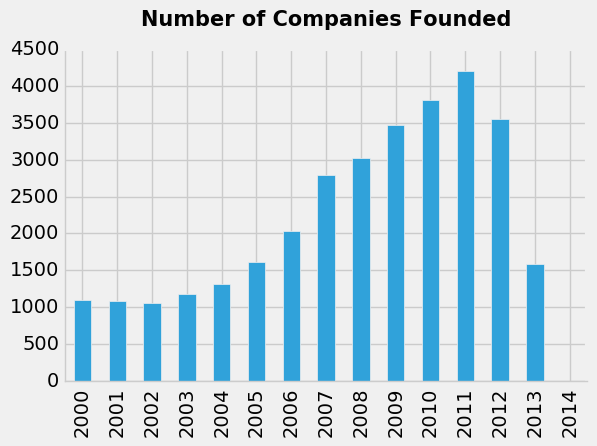

In [8]:
temp = a.groupby(by = [a.founded_at]).id.nunique().reset_index()
temp.rename(columns={'id': 'Amount'}, inplace=True)
ax = temp.plot(x = 'founded_at', y = 'Amount', rot = 90, kind = 'bar')

ax.legend().set_visible(False)

ax.tick_params(axis=u'both', which=u'both',length=0)
ax.spines['bottom'].set_color('#CCCCCC')
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_color('#CCCCCC')
ax.spines['left'].set_linewidth(1)

ax.set_title("Number of Companies Founded", fontweight = 'bold', fontsize = 15, position = [.5,1.05])
ax.set_ylabel("", fontsize = 12, fontstyle = 'italic')
ax.set_xlabel("", fontsize = 12, fontstyle = 'italic')

Our current data shows that the number of companies being founded each year has been increasing in the past few years.   
Ignore 2012 and 2013 b/c its likely that many of the companies founded in those years were likely not listed immediately (remember this dataset is a snapshot of the database at the end of 2013). 

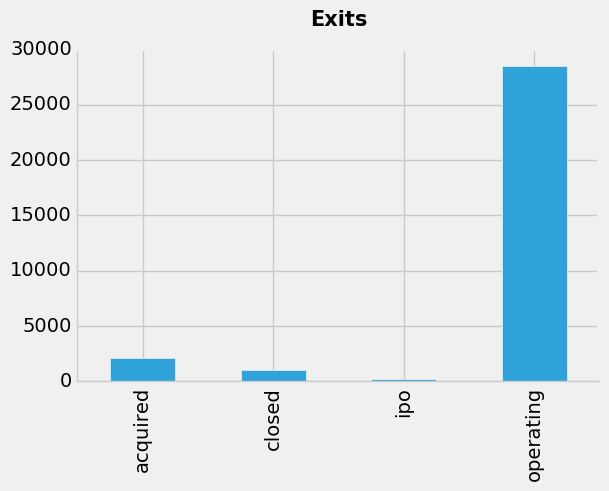

In [9]:
temp = a.groupby(by = [a.status]).id.nunique().reset_index()
temp.rename(columns={'id': 'Amount'}, inplace=True)
ax = temp.plot(x = 'status', y = 'Amount', rot = 90, kind = 'bar')

ax.legend().set_visible(False)

ax.tick_params(axis=u'both', which=u'both',length=0)
ax.spines['bottom'].set_color('#CCCCCC')
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_color('#CCCCCC')
ax.spines['left'].set_linewidth(1)

ax.set_title("Exits", fontweight = 'bold', fontsize = 15, position = [.5,1.05])
ax.set_ylabel("", fontsize = 12, fontstyle = 'italic')
ax.set_xlabel("", fontsize = 12, fontstyle = 'italic')

The number of closed companies is likely to be highly underrepresented in our sample and a large portion of operating companies will likely classify as closed.  
We've got a good number of acquired companies.  
Not so many IPOs though. 
Might be worth excluding them from this study (since they may have wildly different characteristics compared to acquired companies). 

In [10]:
# grab number of offices 
b = cb_offices.groupby(by = [cb_offices.object_id]).office_id.nunique().reset_index()
b.rename(columns={'office_id': 'offices'}, inplace=True)

b.head()

,object_id,offices
0,c:1,2
1,c:10,1
2,c:100,1
3,c:10002,2
4,c:10003,1


In [11]:
# grab number of founders, employees, board members
c = cb_relationships
c = c[['person_object_id', 'relationship_object_id', 'title']]

# if title is board member or investor
c.loc[c["title"].str.contains('board', case=False, na=False), 'Category'] = 'board'

# otherwise if title includes founder
c.loc[c["title"].str.contains('founder', case=False, na=False), 'Category'] = 'founders'

# otherwise employee
c.loc[c.Category.isnull(), 'Category'] = 'employees'

# spread values
c = c.groupby(by = [c.relationship_object_id, c.Category]).person_object_id.nunique().reset_index()
c.rename(columns={'person_object_id': 'count'}, inplace=True)
c = c.pivot_table(index='relationship_object_id', columns='Category', values='count').reset_index()

c.head()

//anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:288: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
//anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
//anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#in

Category,relationship_object_id,board,employees,founders
0,c:1,4.0,5.0,2.0
1,c:10,NaN,NaN,3.0
2,c:100,NaN,2.0,2.0
3,c:1000,NaN,1.0,NaN
4,c:10002,NaN,1.0,1.0


In [12]:
# I was eventually able to get most of the milestones data in
# Line 57 of the sql dump had to be excluded because I couldn't find the error in it so that's a bit dangerous

d = cb_milestones
d = d.groupby(by = ['object_id']).id.nunique().reset_index()
d.rename(columns={'id': 'milestones'}, inplace=True)

d.head(10)

,object_id,milestones
0,c:1,2
1,c:100,1
2,c:10009,1
3,c:1001,2
4,c:10014,1
5,c:10018,1
6,c:10022,1
7,c:100268,2
8,c:100442,1
9,c:10054,2


In [13]:
# Number of funding events
e = cb_funding_rounds

e = e.groupby(by = ['object_id']).funding_round_id.nunique().reset_index()
e.rename(columns={'funding_round_id': 'funding_events'}, inplace=True)

e.head()

,object_id,funding_events
0,c:1,3
1,c:1001,1
2,c:10014,1
3,c:10015,5
4,c:100155,3


In [14]:
# Total raised to date
f = cb_funding_rounds

f = f.groupby(by = ['object_id']).raised_amount_usd.sum().reset_index()
f.rename(columns={'raised_amount_usd': 'total_raised_to_date'}, inplace=True)

f.head()

,object_id,total_raised_to_date
0,c:1,39750000.0
1,c:1001,5000000.0
2,c:10014,NaN
3,c:10015,68069200.0
4,c:100155,10125293.0


In [15]:
# last raised amount
g = cb_funding_rounds

g.funded_at = pd.to_datetime(g.funded_at)
g = g.sort_values(by = ['object_id', 'funded_at'], ascending = False)
g = g.groupby(by = ['object_id']).head(1).reset_index(drop=True)
g = g[['object_id', 'raised_amount_usd']]
g.rename(columns={'raised_amount_usd': 'last_raised_amount'}, inplace=True)

g.head()

,object_id,last_raised_amount
0,c:9998,475000.0
1,c:9995,750000.0
2,c:9994,250000.0
3,c:9989,500000.0
4,c:99853,500000.0


In [16]:
temp = cb_funds

# change different currencies to USD
temp.funded_at = pd.to_datetime(temp.funded_at, errors='coerce')
temp['funded_at_valid'] = temp['funded_at'].isnull()

from currency_converter import CurrencyConverter
cc = CurrencyConverter(fallback_on_missing_rate=True, fallback_on_wrong_date=True)

def temp_func(row):
    if row['raised_currency_code'] == 'USD':
        return row['raised_amount']
    elif row['funded_at_valid']:
        return row['raised_amount']
    else:
        return cc.convert(row['raised_amount'], row['raised_currency_code'], 'USD', date=row['funded_at'])

temp['raised_amount_usd'] = temp.apply(temp_func, axis=1)

# sum fund size
temp = temp.groupby(by = ['object_id']).raised_amount_usd.sum().reset_index()
#temp = temp.sort_values(by = 'raised_amount_usd', ascending=True)
temp = temp[temp['raised_amount_usd']<30000000000] # some weird deric r mcloud fund showing up
temp = temp[temp['raised_amount_usd']>1000000] # anything under $1M is unlikely to be a major fund

temp = pd.merge(temp, 
                cb_objects[cb_objects['entity_type']=='FinancialOrg'][['id', 'name']], 
                how='left', 
                left_on = 'object_id', 
                right_on = 'id')
temp.drop(['id'], axis=1, inplace=True)
temp.rename(columns={'name': 'funder_name'}, inplace=True)
temp.sort_values(by = 'raised_amount_usd', ascending = False)

temp.head()

,object_id,raised_amount_usd,funder_name
0,f:1,2.500000e+09,Greylock Partners
1,f:1002,1.570800e+08,Alven Capital
2,f:10029,1.300000e+08,Redpoint eVentures Brazil
3,f:10043,7.500000e+07,Altimeter Capital
4,f:1006,7.190490e+07,Creathor Venture Management


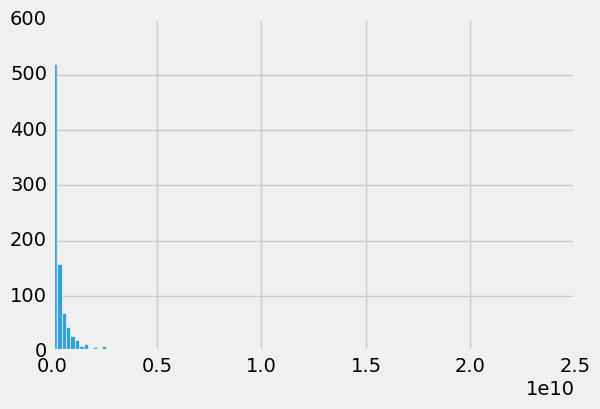

In [17]:
ax = temp.raised_amount_usd.hist(bins = 100)
#ax.set_xlim([0,5000000000])

The vast majority of funds manage less than $0.5 billion.

In [18]:
h = cb_investments
h = h[['investor_object_id', 'funded_object_id']]

#h = pd.merge(h, temp, how='left', left_on = 'investor_object_id', right_on = 'object_id')

temp1 = cb_objects
temp1 = temp1[temp1['entity_type']=='FinancialOrg']
temp1 = temp1[['id', 'name']]
temp1.head()

h = pd.merge(h, temp1, how='left', left_on = 'investor_object_id', right_on = 'id')
h.drop(['id', 'investor_object_id'], axis=1, inplace=True)
h.rename(columns={'name': 'funder_name'}, inplace=True)

h.head()

,funded_object_id,funder_name
0,c:4,Greylock Partners
1,c:4,Omidyar Network
2,c:5,Accel Partners
3,c:5,Greylock Partners
4,c:5,Meritech Capital Partners


In [19]:
# list of 108 top venture capital firms
# Comes from https://en.wikipedia.org/wiki/List_of_venture_capital_firms
# this list is likely biased to the USA
temp = ['3i Group',
'Advanced Technology Ventures',
'Accel Partners',
'Andreessen Horowitz',
'Atlas Venture',
'Atomico',
'August Capital',
'Austin Ventures',
'Avalon Ventures',
'Azure Capital Partners',
'Bain Capital Ventures',
'Balderton Capital',
'Battery Ventures',
'Benchmark',
'Bessemer Venture Partners',
'Binary Capital',
'BitChemy Ventures',
'Black Coral Capital',
'Canvas Venture Fund',
'Carmel Ventures',
'Charles River Ventures',
'Clearstone Venture Partners',
'Columbus Nova Technology Partners',
'Costanoa Venture Capital',
'Crosslink Capital',
'CrunchFund',
'DAG Ventures',
'Data Collective',
'Digital Sky Technologies',
'Draper Fisher Jurvetson (DFJ)',
'Elevation Partners',
'ff Venture Capital',
'Fidelity Ventures',
'FirstMark Capital',
'First Round Capital',
'Flybridge Capital Partners',
'Foundation Capital',
'Founders Fund',
'Galen Partners',
'General Catalyst Partners',
'Genesis Partners',
'Golden Gate Ventures',
'GGV Capital',
'Google Ventures',
'Granite Ventures',
'Greylock Partners',
'Harris & Harris Group',
'HealthCap',
'Highland Capital Partners',
'Horizons Ventures',
'IDG Ventures',
'Initialized Capital',
'Iona Capital',
'In-Q-Tel',
'Index Ventures',
'Innovacom',
'Insight Venture Partners',
'Intel Capital',
'Intellectual Ventures',
'Institutional Venture Partners',
'Internet Capital Group',
'Inventus Capital Partners',
'Israel Cleantech Ventures',
'Jerusalem Venture Partners',
'JMI Equity',
'Kapor Capital',
'Kleiner Perkins Caufield & Byers',
'Khosla Ventures',
'Lightspeed Venture Partners',
'Lux Capital',
'Matrix Partners',
'Maveron',
'Mayfield Fund',
'Menlo Ventures',
'Meritech Capital Partners',
'Morgenthaler Ventures',
'New Enterprise Associates',
'Nexit Ventures',
'Norwest Venture Partners',
'Oak Investment Partners',
'Oregon Angel Fund',
'OpenView Venture Partners',
'Polaris Partners',
'Quicksilver Ventures',
'Radius Ventures',
'Redpoint Ventures',
'Revolution',
'Rho Ventures',
'RRE Ventures',
'Rothenberg Ventures',
'Sante Ventures',
'Scale Venture Partners',
'Shenzhen Capital Group',
'Scottish Equity Partners',
'Sequoia Capital',
'Seventure Partners',
'Sevin Rosen Funds',
'Social Capital',
'Sofinnova Ventures',
'SoftTech VC',
'Spark Capital',
'Tenaya Capital',
'Third Rock Ventures',
'Union Square Ventures',
'U.S. Venture Partners (USVP)',
'VantagePoint Capital Partners',
'Venrock',
'Wellington Partners']

In [20]:
# To see which top funders do not appear in our dataset
i = h
i = i['funder_name'].reset_index().drop_duplicates(subset='funder_name')
i['abc'] = 'yes'

temp1 = pd.DataFrame(temp)
temp1.rename(columns={0: 'funder_name'}, inplace=True)
temp1 = pd.merge(temp1, i, how='left', left_on='funder_name', right_on='funder_name')
temp1 = temp1[temp1.abc.isnull()]
temp1

,funder_name,index,abc
15,Binary Capital,NaN,NaN
16,BitChemy Ventures,NaN,NaN
52,Iona Capital,NaN,NaN
58,Intellectual Ventures,NaN,NaN
86,Revolution,NaN,NaN
104,U.S. Venture Partners (USVP),NaN,NaN


In [21]:
def temp_func(row):
    if row['funder_name'] in temp:
        return 1
    else:
        return 0

h['top_vc_backed'] = h.apply(temp_func, axis=1)
h = h[h.top_vc_backed==1]
h = h[['funded_object_id', 'top_vc_backed']]
h = h.drop_duplicates()
h.head()

,funded_object_id,top_vc_backed
0,c:4,1
2,c:5,1
8,c:9,1
10,c:13,1
11,c:14,1


In [22]:
# number of techcrunch articles
i  = cb_milestones
i = i[['object_id', 'source_url']]

i['valid_url'] = i['source_url'].isnull()

def temp_func(row):
    if row['valid_url']:
        return np.nan
    else: 
        parsed_uri = urlparse(row['source_url'])
        domain = '{uri.scheme}://{uri.netloc}/'.format(uri = parsed_uri)
        return domain

i['source'] = i.apply(temp_func, axis=1)

i = i[i.source.str.contains(pat = 'techcrunch', case = False)==True]
i = i.drop_duplicates()
i = i.groupby(by = ['object_id']).size().reset_index()
i.rename(columns={0: 'tc_articles'}, inplace=True)

i.head()

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,object_id,tc_articles
0,c:1001,1
1,c:10014,1
2,c:10176,3
3,c:1019,2
4,c:1020,1


In [23]:
j = cb_investments
j = j[['investor_object_id', 'funded_object_id']]

j = j.drop_duplicates()
j = j.groupby(by = ['funded_object_id']).size().reset_index()
j.rename(columns={0: 'funders'}, inplace=True)

j.head()

,funded_object_id,funders
0,c:1,4
1,c:1001,3
2,c:10014,1
3,c:10015,7
4,c:100155,4


In [24]:
k = cb_relationships

# otherwise if title includes founder
k.loc[k["title"].str.contains('founder', case=False, na=False), 'category'] = 'founder'

k = k[k['category']=='founder']
k = k[['person_object_id', 'relationship_object_id', 'category']]
k= k.drop_duplicates()

temp = k[['person_object_id', 'relationship_object_id']]
temp.rename(columns={'relationship_object_id': 'assoc_company'}, inplace=True)

k = pd.merge(k, temp, how='left', left_on = 'person_object_id', right_on = 'person_object_id')

def temp_func(row):
    if row['relationship_object_id']==row['assoc_company']:
        return 'same'
    else: 
        return 'different'

k['remove'] = k.apply(temp_func, axis=1)
k = k[k['remove']=='different']

k = k.groupby(by = ['relationship_object_id']).assoc_company.nunique().reset_index()
k.rename(columns={'assoc_company': 'companies_founded'}, inplace=True)

k.head(10)
#len(k)

//anaconda/lib/python3.5/site-packages/pandas/core/frame.py:2754: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


,relationship_object_id,companies_founded
0,c:1,1
1,c:10,1
2,c:10010,2
3,c:10012,2
4,c:10014,2
5,c:10042,1
6,c:10057,1
7,c:10062,1
8,c:1007,3
9,c:10073,2


In [25]:
# put it all together 

# list of companies
all_data = a

# number of offices
all_data = pd.merge(all_data, b, how='left', left_on = 'id', right_on = 'object_id')
all_data.drop('object_id', axis=1, inplace=True)

# number of founders, employees, board members
all_data = pd.merge(all_data, c, how='left', left_on = 'id', right_on = 'relationship_object_id')
all_data.drop('relationship_object_id', axis=1, inplace=True)

# number of milestones
all_data = pd.merge(all_data, d, how='left', left_on = 'id', right_on = 'object_id')
all_data.drop('object_id', axis=1, inplace=True)
#all_data.milestones.fillna(inplace=True, value=0)

# number of funding events
all_data = pd.merge(all_data, e, how='left', left_on = 'id', right_on = 'object_id')
all_data.drop('object_id', axis=1, inplace=True)
#all_data.funding_events.fillna(inplace=True, value=0)

# number of funders
#all_data = pd.merge(all_data, j, how='left', left_on = 'id', right_on = 'funded_object_id')
#all_data.drop('funded_object_id', axis=1, inplace=True)
#all_data.funders.fillna(inplace=True, value=0)
# remove rows where a company has had multiple funding events but 0 funders, makes no logical sense
# only XXXX rows removed
#all_data = all_data[np.logical_not((all_data.funding_events>0) & (all_data.funders==0))]

# total funding raised to date
all_data = pd.merge(all_data, f, how='left', left_on = 'id', right_on = 'object_id')
all_data.drop('object_id', axis=1, inplace=True)
#all_data.total_raised_to_date.fillna(inplace=True, value=0)

# last raised funding amount
all_data = pd.merge(all_data, g, how='left', left_on = 'id', right_on = 'object_id')
all_data.drop('object_id', axis=1, inplace=True)
#all_data.last_raised_amount.fillna(inplace=True, value=0)
# remove rows where a company has had multiple funding events but 0 actual funding, makes no logical sense
# only 1117 rows removed
all_data = all_data[np.logical_not((all_data.funding_events>0) & (all_data.total_raised_to_date==0))]

# top vc backing 
all_data = pd.merge(all_data, h, how='left', left_on = 'id', right_on = 'funded_object_id')
all_data.drop('funded_object_id', axis=1, inplace=True)
#all_data.top_vc_backed.fillna(inplace=True, value=0)

# number of techcrunch articles
all_data = pd.merge(all_data, i, how='left', left_on = 'id', right_on = 'object_id')
all_data.drop('object_id', axis=1, inplace=True)
#all_data.tc_articles.fillna(inplace=True, value=0)

# number of companies founded by founders previously
all_data = pd.merge(all_data, k, how='left', left_on = 'id', right_on = 'relationship_object_id')
all_data.drop('relationship_object_id', axis=1, inplace=True)
#all_data.companies_founded.fillna(inplace=True, value=0)

# number of twitter followers
# twitter sentiment analysis

all_data.head(25)
#len(all_data)

,id,entity_type,name,category_code,status,founded_at,country_code,region,twitter_username,homepage_url,...,board,employees,founders,milestones,funding_events,total_raised_to_date,last_raised_amount,top_vc_backed,tc_articles,companies_founded
0,c:1,Company,Wetpaint,web,operating,2005,USA,Seattle,BachelrWetpaint,http://wetpaint-inc.com,...,4.0,5.0,2.0,2.0,3.0,39750000.0,25000000.0,1.0,NaN,1.0
1,c:10009,Company,dimension5 labs,advertising,operating,2008,USA,Santa Fe,NaN,http://d5labs.com,...,NaN,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2,c:1001,Company,FriendFeed,web,acquired,2007,USA,SF Bay,friendfeed,http://friendfeed.com,...,1.0,4.0,4.0,2.0,1.0,5000000.0,5000000.0,1.0,1.0,NaN
3,c:10011,Company,PoetryVisualized.com,games_video,operating,2008,USA,San Diego,NaN,http://www.poetryvisualized.com,...,NaN,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,c:10014,Company,Mobclix,mobile,acquired,2008,USA,SF Bay,mobclix,http://www.mobclix.com,...,NaN,5.0,1.0,1.0,1.0,NaN,NaN,NaN,1.0,2.0
5,c:10015,Company,Fitbit,health,operating,2007,USA,SF Bay,fitbit,http://www.fitbit.com,...,1.0,6.0,1.0,NaN,5.0,68069200.0,43000000.0,1.0,NaN,NaN
6,c:100155,Company,MTPV,cleantech,operating,2003,USA,Austin,NaN,http://www.mtpv.com,...,2.0,1.0,NaN,NaN,3.0,10125293.0,3250000.0,NaN,NaN,NaN
7,c:10018,Company,Demandbase,analytics,operating,2006,USA,SF Bay,Demandbase,http://www.demandbase.com,...,NaN,10.0,1.0,1.0,3.0,33000000.0,15000000.0,1.0,NaN,NaN
8,c:100180,Company,AirSpeed,software,operating,2011,USA,SF Bay,airspeedapp,http://www.airspeedapp.com,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,c:100212,Company,Betts Recruiting,consulting,operating,2009,USA,unknown,BettsRecruiting,http://www.bettsrecruiting.com,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Dataset description

One of the problems with public datasets like ours is that there can be a lot of missing data resulting in sparsely populated dataset.  
Lets take look at the sparsity.   

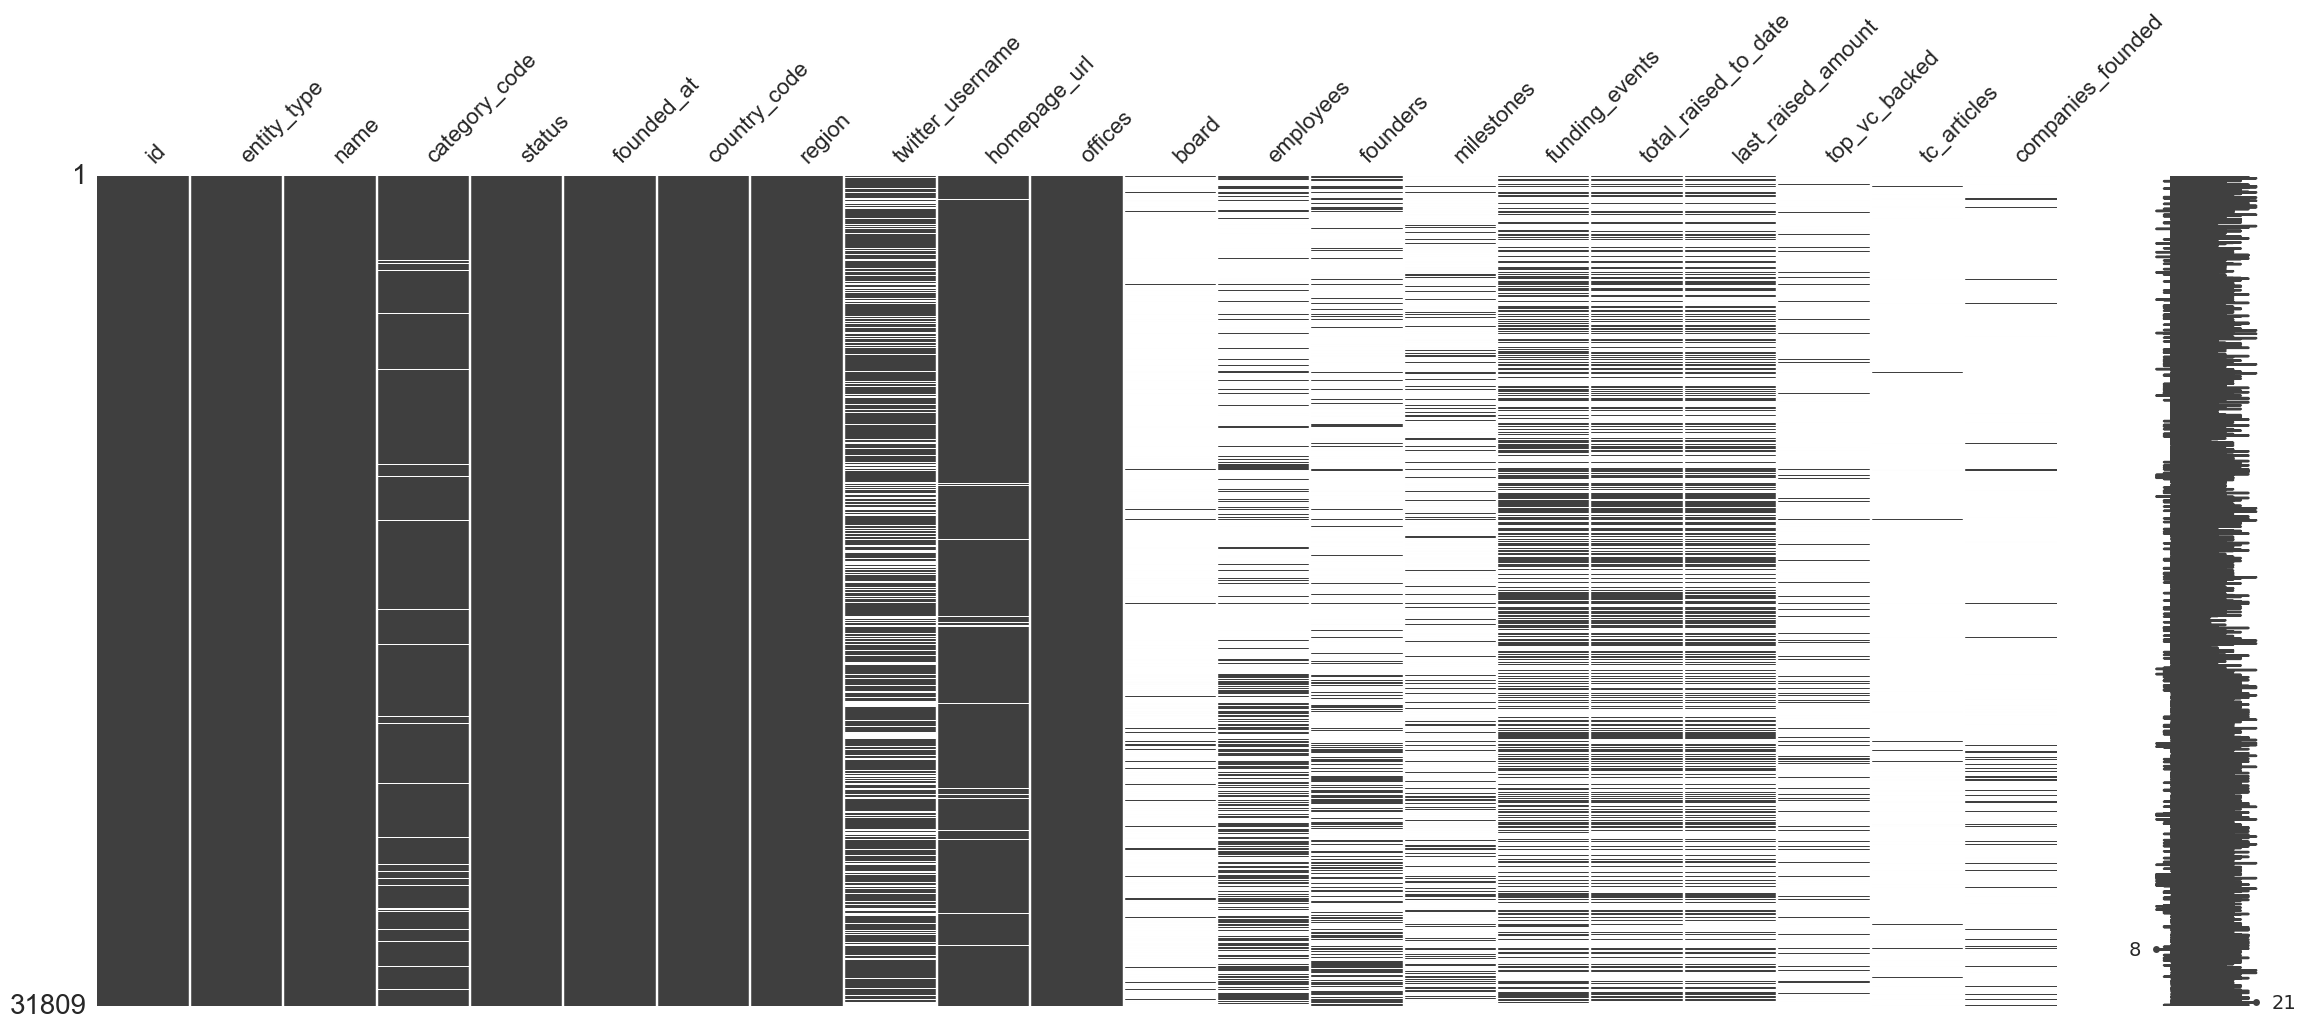

In [26]:
import missingno as msno
msno.matrix(all_data)

Immediately we can see that some features have unacceptably poor data.  
These features are:  
 * board
 * tc articles
 * companies founded  

We also see something quite strange.  
We have complete data for offices. I assume that CrunchBase gives all startups 1 office by default which would be a fair assumption if this is the case.  

Let's drop these from our dataset.  
SHOULD I REMOVE COLUMNS WITH LOTS OF MISSING DATA EVEN? The backbone of any machine learning method is the number of features you can give it. 

In [27]:
all_data = all_data.drop(['board','tc_articles', 'companies_founded'], axis=1)

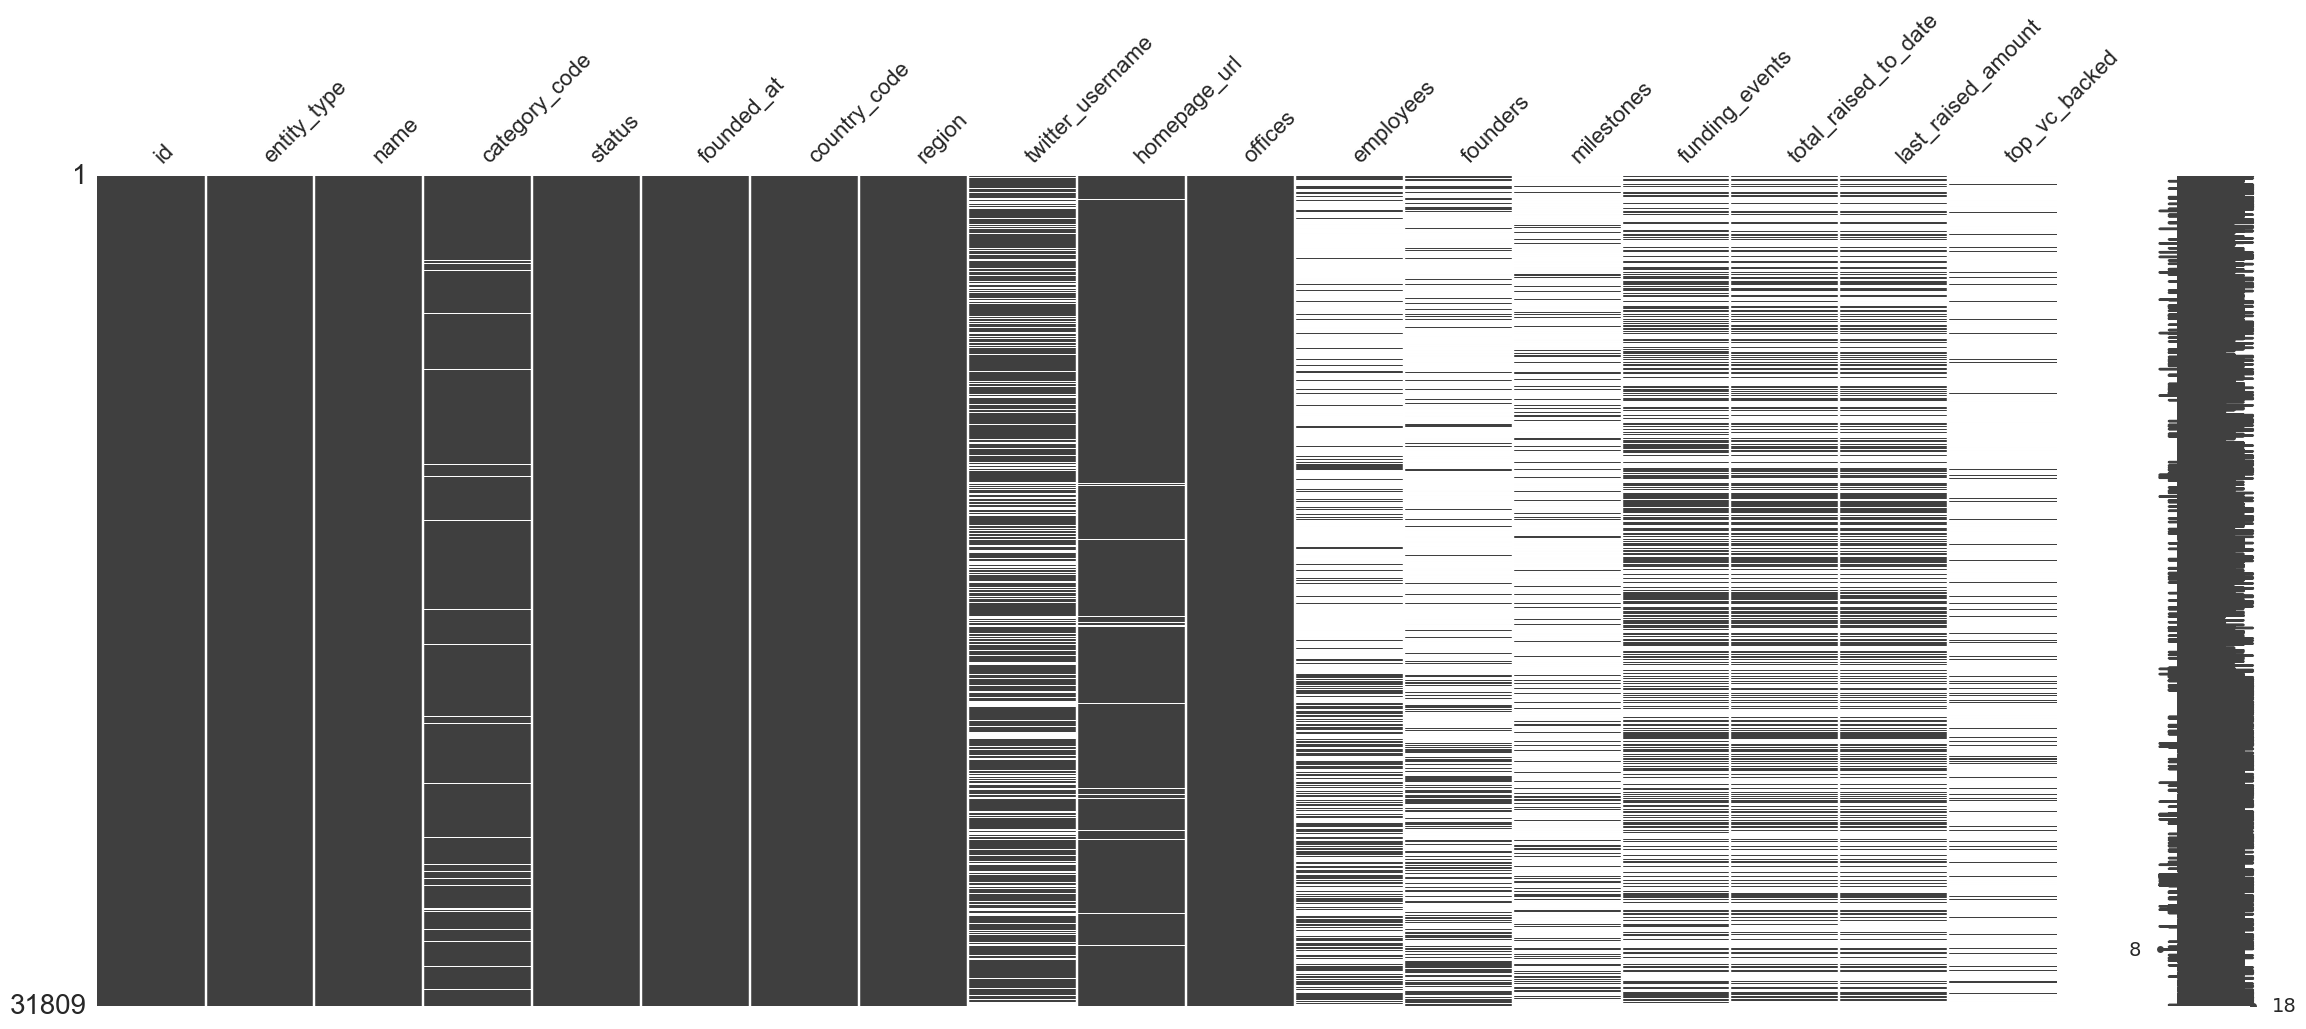

In [28]:
msno.matrix(all_data)

That looks better.  
Now, can we make reasonable assumptions for missing data in the remaining features?  
This is certainly possible since data is unlikely to to be missing at random.  

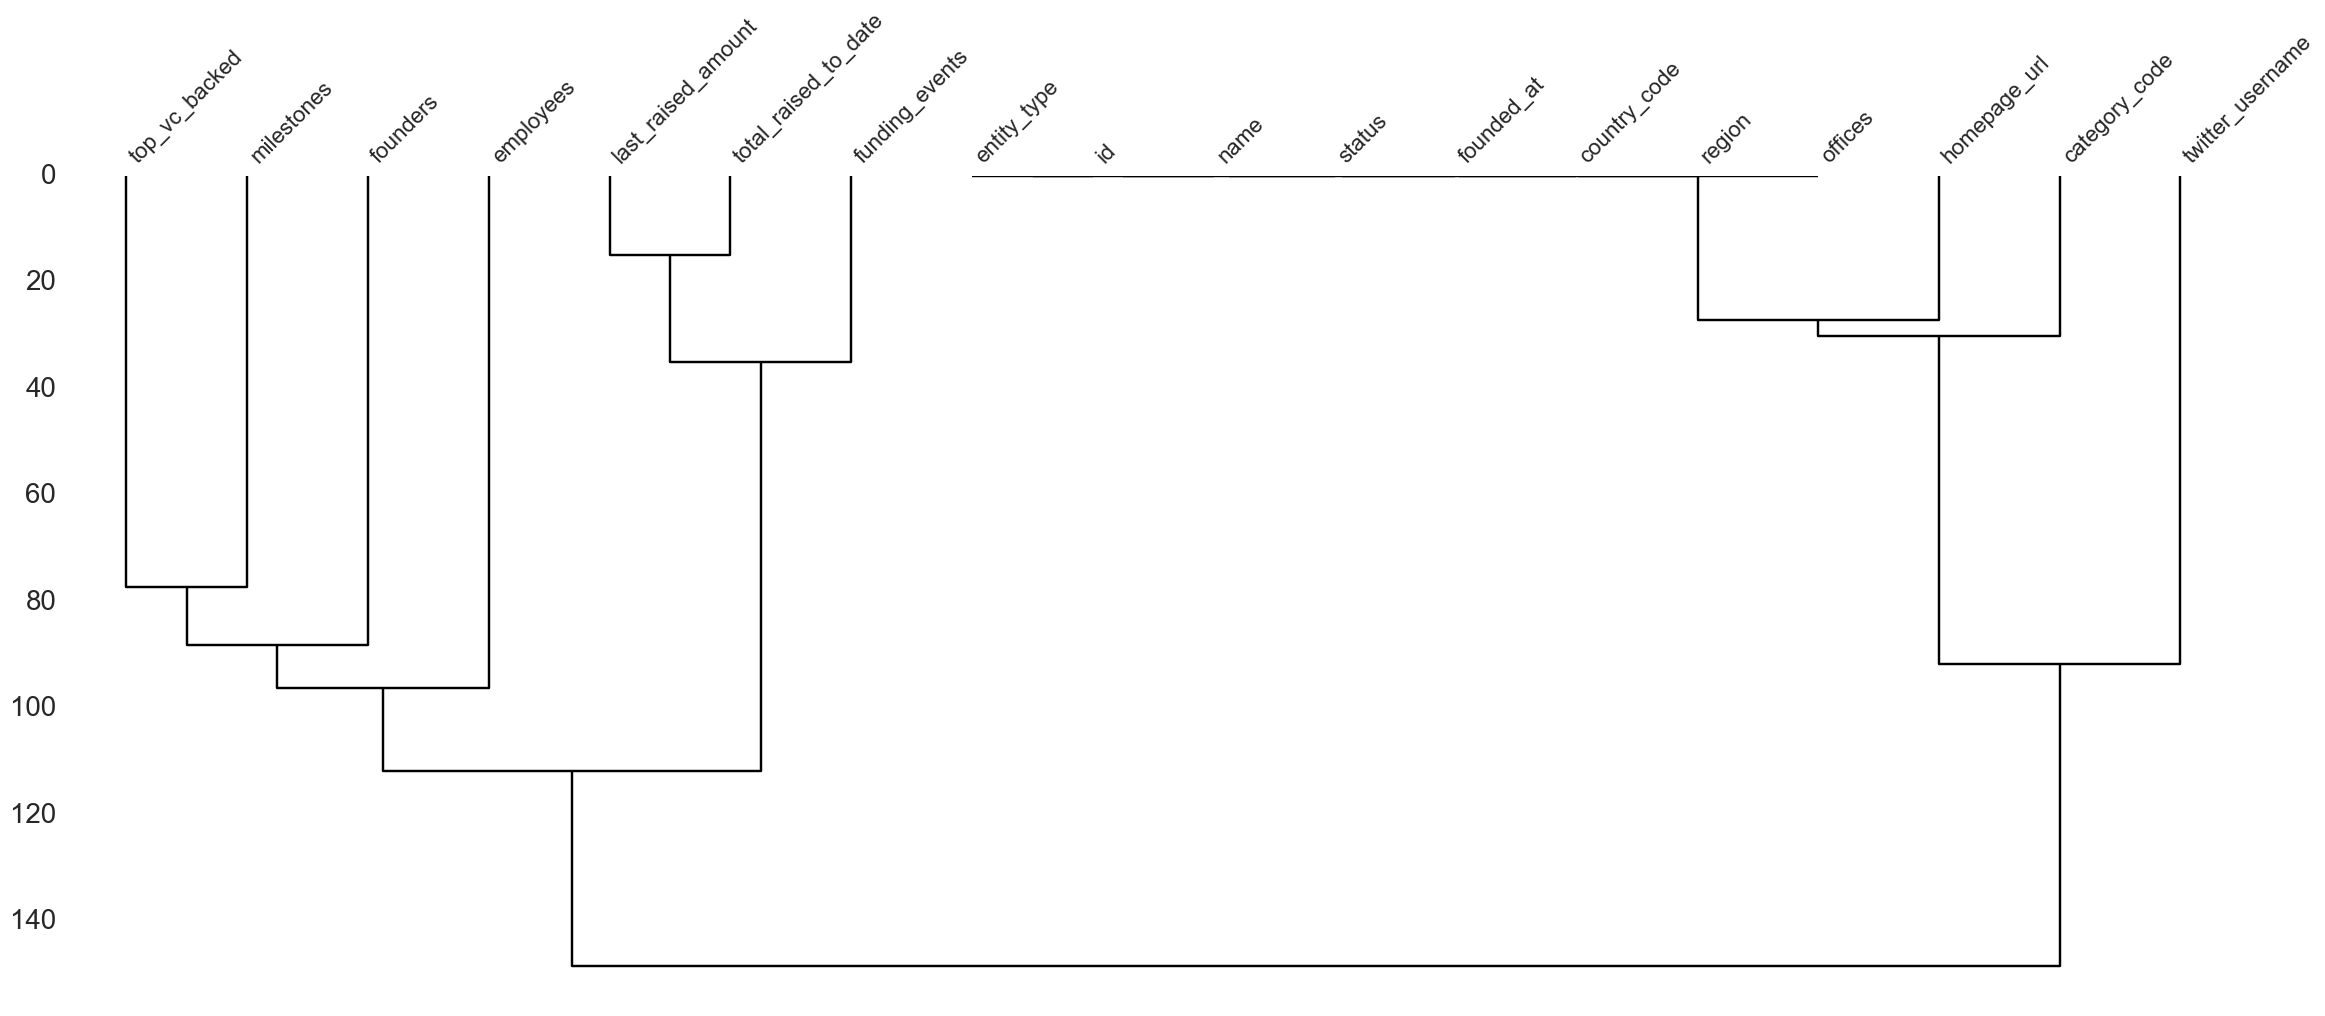

In [29]:
msno.dendrogram(all_data)

The above visualization shows some interesting patterns.  
We see that companies that are backed by venture capital (top_vc_backed) are more likely to have milestones (milestones). This is despite the fact that these two variables comes from different datasets.  
This is actually not too surprising since a lot of milestones will be anouncements of a company successfully raising money from VCs. Still, this is nice to see in the data.  
Coming back to the problem of missing data, we can assume where for example milestones data is missing, the company has achieved 0 milestones.  
Similarly, where we are missing data for number of founders we can assume the company had 1 founder.  
SHOULD I EVEN DO THIS? IT SEEMS BAYESIAN METHODS CAN HANDLE MISSING DATA?

In [30]:
all_data.milestones.fillna(inplace=True, value=0)
all_data.funding_events.fillna(inplace=True, value=0)
all_data.total_raised_to_date.fillna(inplace=True, value=0)
all_data.last_raised_amount.fillna(inplace=True, value=0)
all_data.top_vc_backed.fillna(inplace=True, value=0)
#all_data.companies_founded.fillna(inplace=True, value=0)

# Naive Bayes

We're going to try a naive bayes model for this classification task.  

In [31]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.cross_validation import train_test_split

train, test = train_test_split(all_data, test_size = 0.2)

//anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [32]:
len(train)

25447

In [33]:
len(test)

6362

# Data analysis

Alright, so we have a wealth of data in the above table. 
The columns we'll largely use for modelling and plotting will be the following: 
 * funding_round_type
 * raised_amount_usd
 * funded_at
 * participants
 
Let's try plotting some of this data.  
We'll start with jut plotting all the daily funding activity over the last few years.  

In [34]:
cb_funding_rounds.funded_at = pd.to_datetime(cb_funding_rounds.funded_at)

a = cb_funding_rounds
a = a[a.funding_round_type != 'post-ipo'] # remove post ipo rounds
a = a[a.funding_round_type != 'other'] # remove other (debt, grants) rounds
a = a[a.funding_round_type != 'private-equity'] # remove private-equity rounds 

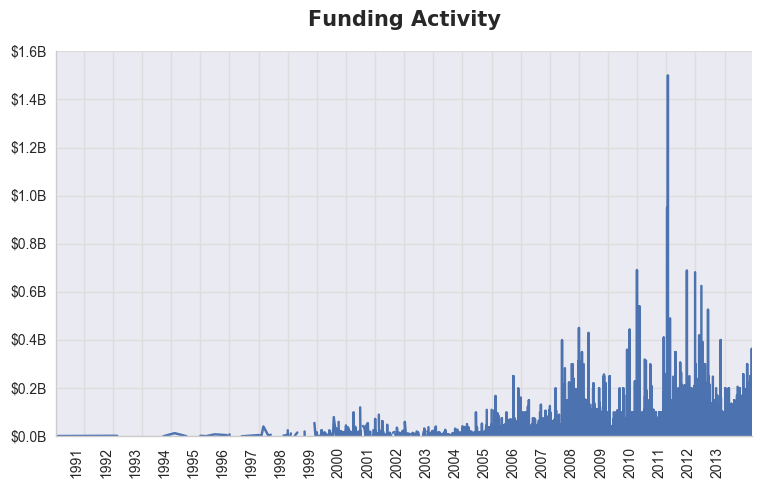

In [35]:
b = a[a.funded_at.dt.year >= 1990]

ax = b.plot(x = 'funded_at', y = 'raised_amount_usd', rot = 90)

def pct(x,pos): return "${}B".format((x/1000000000))
ax.yaxis.set_major_formatter(plt.FuncFormatter(pct))
#ax.set_ylim([0,2000000000])

#ax.patch.set_facecolor('#FFFFFF')
ax.grid(b = True, which = 'major', color = '#DDDDDD', linestyle = '-')
ax.legend().set_visible(False)

ax.tick_params(axis=u'both', which=u'both',length=0)
ax.spines['bottom'].set_color('#CCCCCC')
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_color('#CCCCCC')
ax.spines['left'].set_linewidth(1)

ax.set_title("Funding Activity", fontweight = 'bold', fontsize = 15, position = [.5,1.05])
ax.set_ylabel("", fontsize = 12, fontstyle = 'italic')
ax.set_xlabel("", fontsize = 12, fontstyle = 'italic')
import matplotlib.dates as dates

ax.xaxis.set_major_locator(dates.YearLocator())

We can see a few things from the above graph. 
* Funding activity has been increasing over time. 
* Funding activity can be characterised as having boom years and bust years. 
* Notwithstanding the above, funding activity appears to be lumpy. 

Let's take a quick look at how big the average funding round was in each year. 

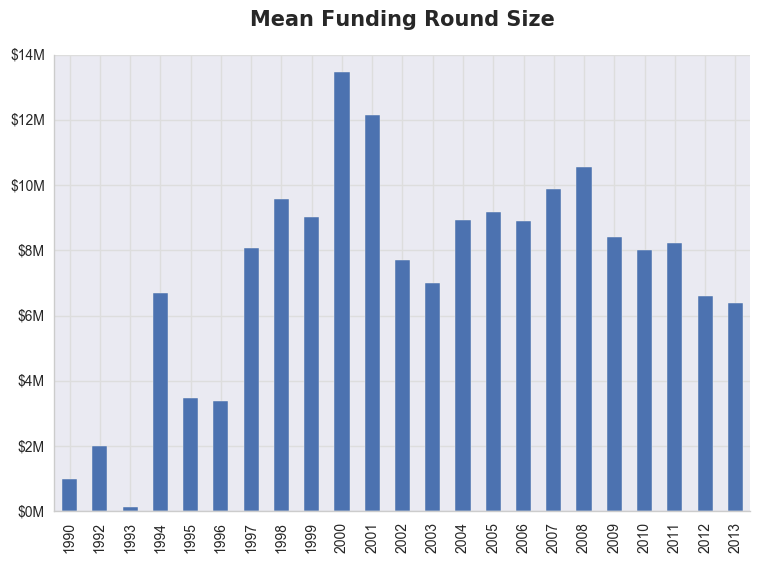

In [36]:
b = a[a.funded_at.dt.year >= 1990]
b = b.groupby(by = [b.funded_at.dt.year]).mean().reset_index()

ax = b.plot(x = 'funded_at', y = 'raised_amount_usd', rot = 90, kind = 'bar')

def pct(x,pos): return "${}M".format(int(x/1000000))
ax.yaxis.set_major_formatter(plt.FuncFormatter(pct))
#ax.set_ylim([0,2000000000])

#ax.patch.set_facecolor('#FFFFFF')
ax.grid(b = True, which = 'major', color = '#DDDDDD', linestyle = '-')
ax.legend().set_visible(False)

ax.tick_params(axis=u'both', which=u'both',length=0)
ax.spines['bottom'].set_color('#CCCCCC')
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_color('#CCCCCC')
ax.spines['left'].set_linewidth(1)

ax.set_title("Mean Funding Round Size", fontweight = 'bold', fontsize = 15, position = [.5,1.05])
ax.set_ylabel("", fontsize = 12, fontstyle = 'italic')
ax.set_xlabel("", fontsize = 12, fontstyle = 'italic')

#import matplotlib.dates as dates
#ax.xaxis.set_major_locator(dates.MonthLocator())

We can see the dotcom bubble quite clearly here.  
Average funding peaked around the year 2000 and has not come anywhere close since. 

Now let's take a look at daily Funding activity for the last 3 years, the last year we have data upon. 

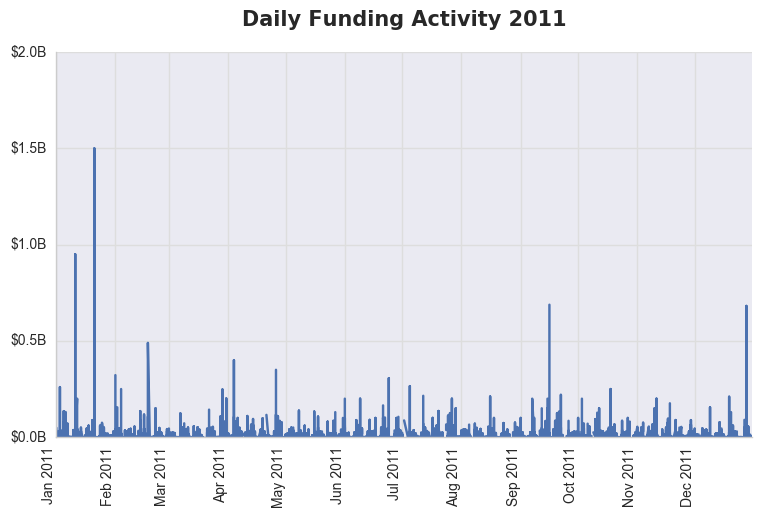

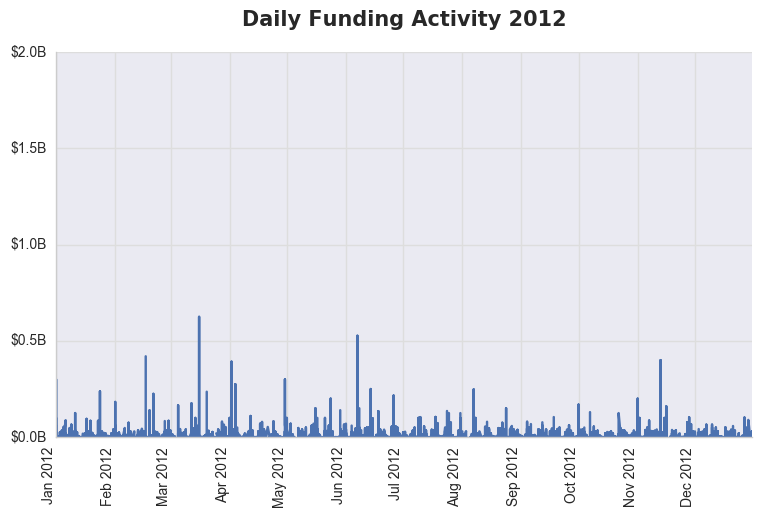

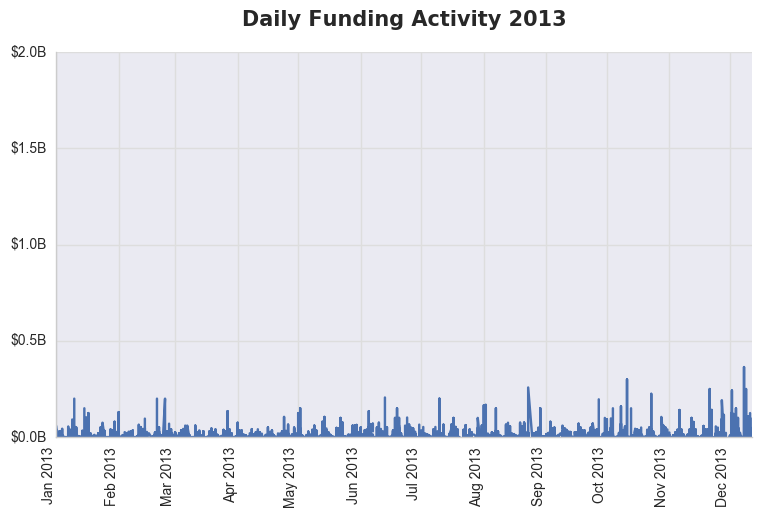

In [37]:
b = a[a.funded_at.dt.year >= 2011]

for group in range(2011,2014):
    
    c = b[b.funded_at.dt.year == group]
    
    ax = c.plot(x = 'funded_at', y = 'raised_amount_usd', rot = 90)

    def pct(x,pos): return "${}B".format((x/1000000000))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(pct))
    ax.set_ylim([0,2000000000])

    #ax.patch.set_facecolor('#FFFFFF')
    ax.grid(b = True, which = 'major', color = '#DDDDDD', linestyle = '-')
    ax.legend().set_visible(False)

    ax.tick_params(axis=u'both', which=u'both',length=0)
    ax.spines['bottom'].set_color('#CCCCCC')
    ax.spines['bottom'].set_linewidth(1)
    ax.spines['left'].set_color('#CCCCCC')
    ax.spines['left'].set_linewidth(1)

    ax.set_title("Daily Funding Activity " + str(group), fontweight = 'bold', fontsize = 15, position = [.5,1.05])
    ax.set_ylabel("", fontsize = 12, fontstyle = 'italic')
    ax.set_xlabel("", fontsize = 12, fontstyle = 'italic')

    #import matplotlib.dates as dates
    ax.xaxis.set_major_locator(dates.MonthLocator())

We see there are some days where absolutely massive amounts of capital were deployed but other than that, nothing particularly insightful here.  

Next, let's look at mean funding for each month.  

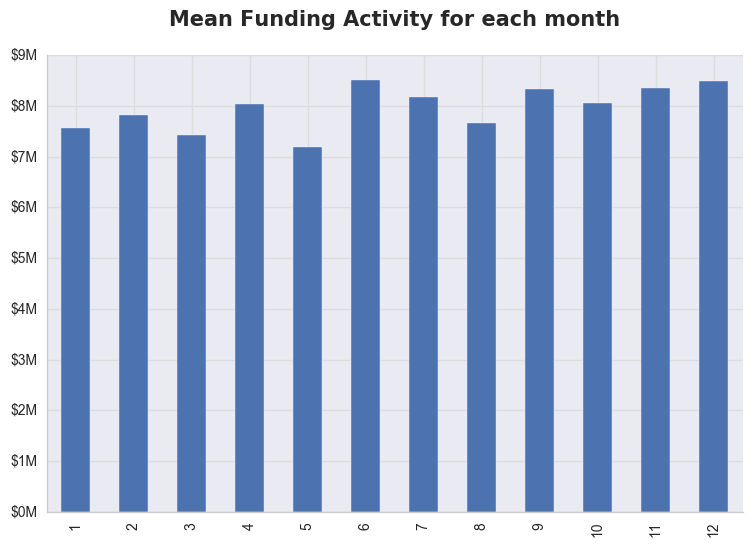

In [38]:
b = a[a.funded_at.dt.year >= 1990]
b = b.groupby(by = [b.funded_at.dt.month]).mean().reset_index()

ax = b.plot(x = 'funded_at', y = 'raised_amount_usd', rot = 90, kind = 'bar')

def pct(x,pos): return "${}M".format(int(x/1000000))
ax.yaxis.set_major_formatter(plt.FuncFormatter(pct))
#ax.set_ylim([0,2000000000])

#ax.patch.set_facecolor('#FFFFFF')
ax.grid(b = True, which = 'major', color = '#DDDDDD', linestyle = '-')
ax.legend().set_visible(False)

ax.tick_params(axis=u'both', which=u'both',length=0)
ax.spines['bottom'].set_color('#CCCCCC')
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_color('#CCCCCC')
ax.spines['left'].set_linewidth(1)

ax.set_title("Mean Funding Activity for each month", fontweight = 'bold', fontsize = 15, position = [.5,1.05])
ax.set_ylabel("", fontsize = 12, fontstyle = 'italic')
ax.set_xlabel("", fontsize = 12, fontstyle = 'italic')

#import matplotlib.dates as dates
#ax.xaxis.set_major_locator(dates.MonthLocator())

Not much variation between the different months.  
That's quite interesting.  
One might assume that there would be less activity in the latter part of the year but this clearly doesn't appear to be the case. Good to know. 

Alright, one thing you hear a lot about is how series A is the new series B and the series B is the new series C.   
Let's try to see if this is actually true for most ventures by looking at median size of each round in each year.  

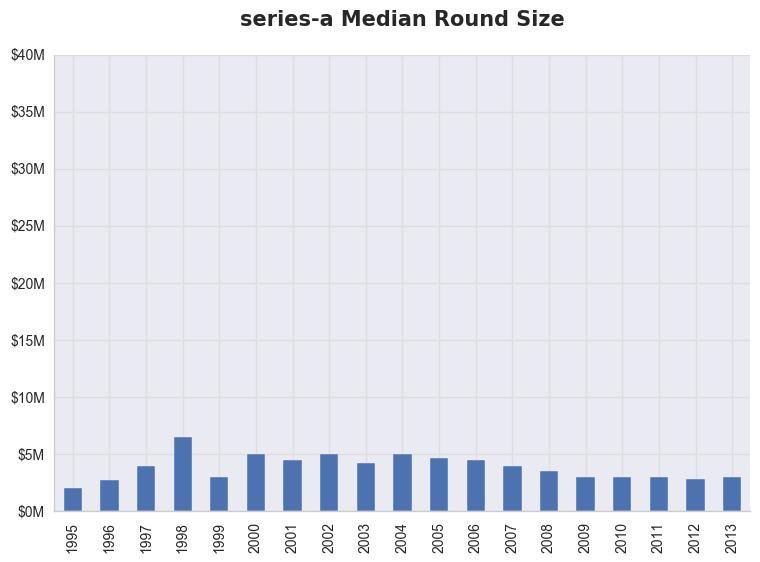

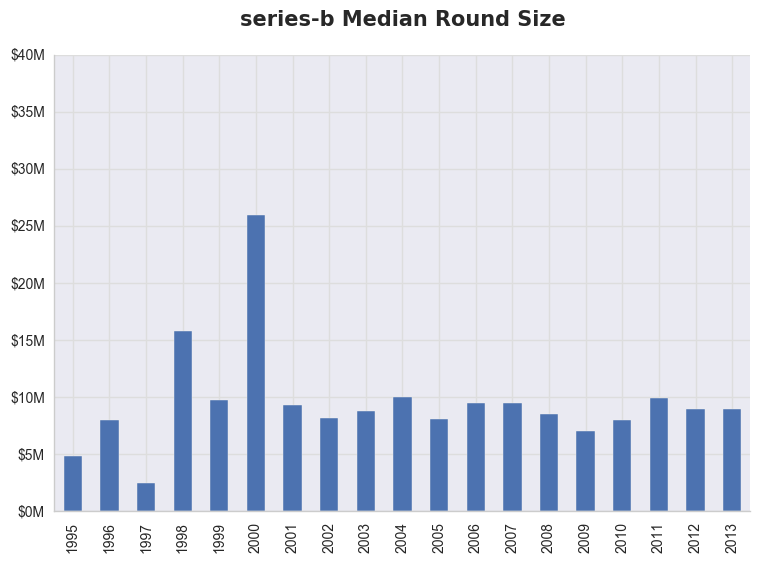

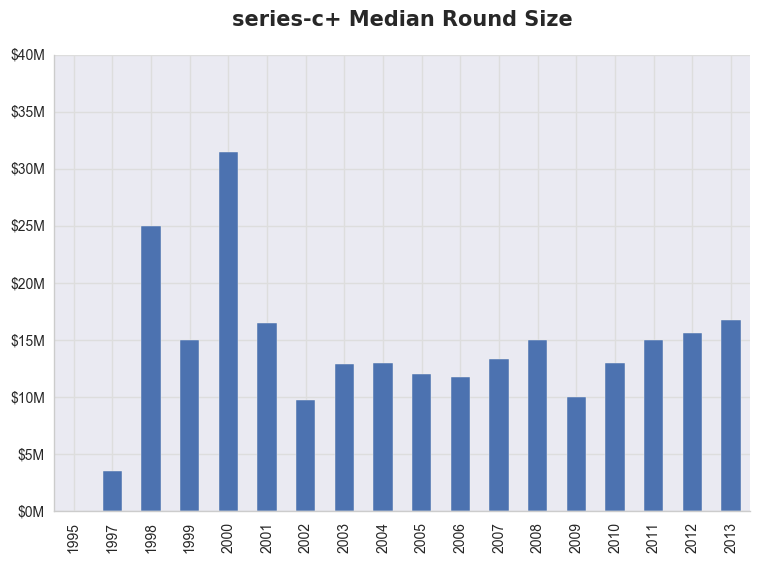

In [39]:
b = a[a.funded_at.dt.year >= 1990]
b = b[b.funding_round_type.isin(['series-a', 'series-b', 'series-c+'])]
b = b.groupby(by = [b.funded_at.dt.year, b.funding_round_type])['raised_amount_usd'].median().reset_index()

for group in b.funding_round_type.unique():
    
    c = b[b.funding_round_type == group]

    ax = c.plot(x = 'funded_at', y = 'raised_amount_usd', rot = 90, kind = 'bar')

    def pct(x,pos): return "${}M".format(int(x/1000000))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(pct))
    ax.set_ylim([0,40000000])

    #ax.patch.set_facecolor('#FFFFFF')
    ax.grid(b = True, which = 'major', color = '#DDDDDD', linestyle = '-')
    ax.legend().set_visible(False)

    ax.tick_params(axis=u'both', which=u'both',length=0)
    ax.spines['bottom'].set_color('#CCCCCC')
    ax.spines['bottom'].set_linewidth(1)
    ax.spines['left'].set_color('#CCCCCC')
    ax.spines['left'].set_linewidth(1)

    ax.set_title(group + " Median Round Size", fontweight = 'bold', fontsize = 15, position = [.5,1.05])
    ax.set_ylabel("", fontsize = 12, fontstyle = 'italic')
    ax.set_xlabel("", fontsize = 12, fontstyle = 'italic')

    #import matplotlib.dates as dates
    #ax.xaxis.set_major_locator(dates.MonthLocator())

We can see series B and series C haven't changed much over the years.  
Series A on the other hand seems to be becoming smaller and smaller.  
This makes sense if you consider that many of the activities that early stage startups typically do (e.g. prototyping) has become considerably cheaper over time.  

Let's see what some of the biggest raises in each year were and if there are any familiar names. 

In [40]:
b = a[a.funded_at.dt.year >= 1990]
b = b.loc[b.groupby(by = [b.funded_at.dt.year])['raised_amount_usd'].idxmax()]
b = pd.merge(b, cb_objects, how='left', left_on = 'object_id', right_on = 'id')
b = b[['funded_at', 'name', 'raised_amount_usd']]

b

,funded_at,name,raised_amount_usd
0,1990-01-17,RampRate Sourcing Advisors,1.000000e+06
1,1992-02-22,Viewpoint Digital,2.000000e+06
2,1993-09-23,JAD Tech Consulting,1.250000e+05
3,1994-02-12,Viewpoint Digital,1.300000e+07
4,1995-07-01,Amazon,8.000000e+06
5,1996-01-01,GeoCities,8.000000e+06
6,1997-03-01,Global Crossing,4.100000e+07
7,1998-12-01,Priceline,5.535000e+07
8,1999-08-01,BIGWORDS.com,8.000000e+07
9,2000-06-27,Opsware,1.200000e+08


Paypal, Priceline, Facebook, these are all familiar names.  
We also see some very unfamiliar names which is concerning. 

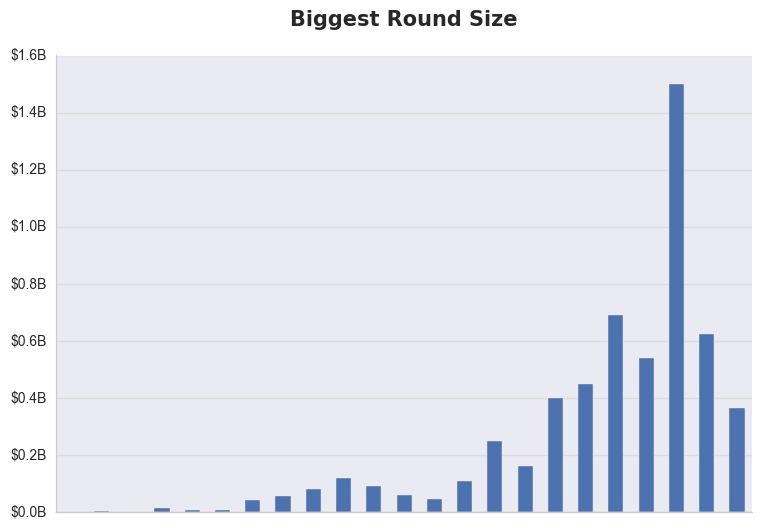

In [41]:
ax = b.plot(x = 'funded_at', y = 'raised_amount_usd', rot = 90, kind = 'bar')

def pct(x,pos): return "${}B".format(round(x/1000000000, 1))
ax.yaxis.set_major_formatter(plt.FuncFormatter(pct))
#ax.set_ylim([0,2000000000])

#ax.patch.set_facecolor('#FFFFFF')
ax.grid(b = True, which = 'major', color = '#DDDDDD', linestyle = '-')
ax.legend().set_visible(False)

ax.tick_params(axis=u'both', which=u'both',length=0)
ax.spines['bottom'].set_color('#CCCCCC')
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_color('#CCCCCC')
ax.spines['left'].set_linewidth(1)

ax.set_title("Biggest Round Size", fontweight = 'bold', fontsize = 15, position = [.5,1.05])
ax.set_ylabel("", fontsize = 12, fontstyle = 'italic')
ax.set_xlabel("", fontsize = 12, fontstyle = 'italic')

ax.xaxis.set_major_locator(dates.YearLocator())

The general trend is that each year there's a bigger round than the previous biggest.  
With companies like Uber, Airbnb, Snap planning IPOs, we can expect to continue seeing this trend (at least until the next crash. 

# Topic Modelling

In this section, I'll try to use an LDA model to do some basic topic modelling. 

In [42]:
from urllib.parse import urlparse

a = cb_milestones
a = a[['object_id', 'source_url']]

Let's see where most of the URLs are coming from

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


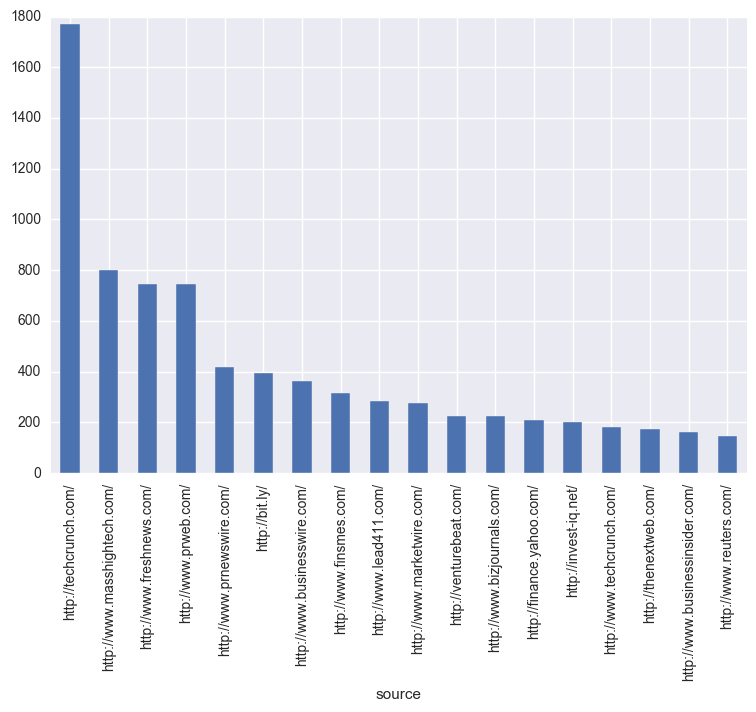

In [43]:
b = a

b['valid_url'] = b['source_url'].isnull()

def temp_func(row):
    if row['valid_url']:
        return np.nan
    else: 
        parsed_uri = urlparse(row['source_url'])
        domain = '{uri.scheme}://{uri.netloc}/'.format(uri = parsed_uri)
        return domain

b['source'] = b.apply(temp_func, axis=1)

b = b.groupby(by = ['source']).size().reset_index()
b.rename(columns={0: 'Amount'}, inplace=True)
b = b.sort_values(by = 'Amount', ascending = False)
b = b[b['Amount']>140]

ax = b.plot(x = 'source', y = 'Amount', rot = 90, kind = 'bar')
ax.legend().set_visible(False)

We'll focus on only on TechCrunch scraping articles.  
TechCrunch is considered to be the authoritative Silicon Valley blog.  
Not all of these can be easily scraped e.g. bit.ly links which can lead to any website and I don't have the time as a one-man team to figure out how to do it with random websites.  

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


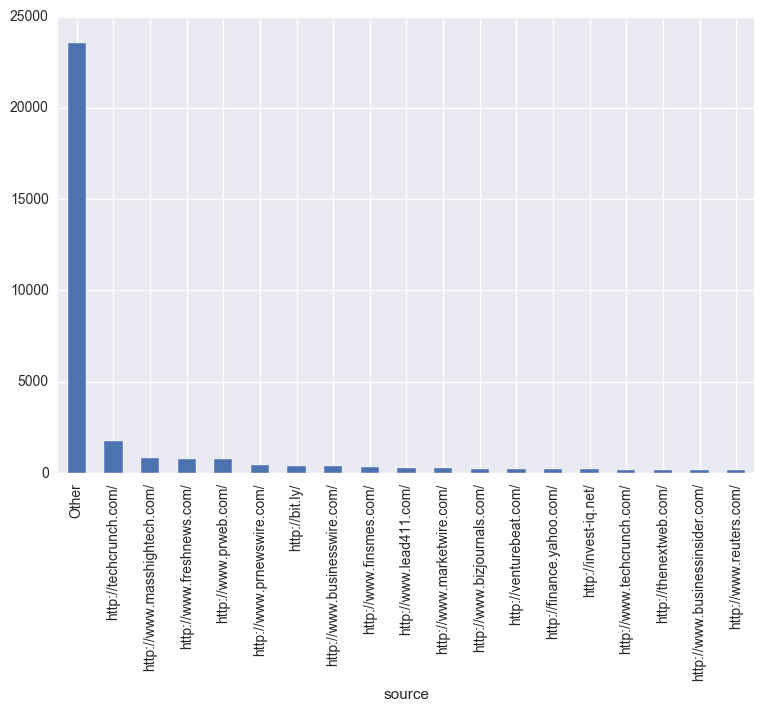

In [44]:
b = a

b['valid_url'] = b['source_url'].isnull()

def temp_func(row):
    if row['valid_url']:
        return np.nan
    else: 
        parsed_uri = urlparse(row['source_url'])
        domain = '{uri.scheme}://{uri.netloc}/'.format(uri = parsed_uri)
        return domain

b['source'] = b.apply(temp_func, axis=1)

b = b.groupby(by = ['source']).size().reset_index()
b.rename(columns={0: 'Amount'}, inplace=True)
b['source'] = np.where(b['Amount']<140, 'Other', b['source'])
b = b.groupby(by = ['source'])['Amount'].sum().reset_index()
b = b.sort_values(by = 'Amount', ascending = False)

ax = b.plot(x = 'source', y = 'Amount', rot = 90, kind = 'bar')
ax.legend().set_visible(False)

Unfortunately, we will be losing the bulk of the data here as most article mentions of companies in the dataset happens outside of our select sources. However this isn't too big of a problem as really what we're trying to capture in our model is whether or not a company gets a mention in an article on a well-known site. 

In [45]:
b = a
b = b.dropna(subset=['source_url'])

# The sources we want to keep and also their tags for scraping which we'll need later on
temp = {}
temp["http://techcrunch.com/"] = "soup.find('div', {'class': 'article-entry text'}).get_text()"
temp["http://www.techcrunch.com/"] = "soup.find('div', {'class': 'article-entry text'}).get_text()"
temp["http://eu.techcrunch.com/"] = "soup.find('div', {'class': 'article-entry text'}).get_text()"
temp["http://www.prnewswire.com"] = "soup.find('section', {'class': 'release-body container '}).get_text()"
temp["http://www.prweb.com/"] = "soup.find('div', {'class': 'article-text'}).get_text()"
temp["http://www.businesswire.com/"] = "soup.find('div', {'class': 'bw-release-story'}).get_text()"
temp["http://www.finsmes.com/"] = "soup.find('div', {'class': 'entry-content'}).get_text()"
temp["http://www.marketwire.com/"] = "soup.find('div', {'class': 'mw_release'}).get_text()"
temp["http://venturebeat.com/"] = "soup.find('div', {'class': 'article-content'}).get_text()"
temp["http://finance.yahoo.com/"] = "soup.find('div', {'class': 'canvas-body C(#26282a) Wow(bw) Cl(start) Mb(20px) Fz(15px) Lh(1.6) Ff($ff-secondary)'}).get_text()"
temp["http://thenextweb.com/"] = "soup.find('div', {'class': 'post-body fb-quotable u-m-3'}).get_text()"
temp["http://www.businessinsider.com/"] = "soup.find('div', {'class': 'clear-both'}).get_text()"
temp["http://www.reuters.com/"] = "soup.find('span', {'id': 'article-text'}).get_text()"


def temp_func(row):
    if np.logical_not(row['source'] in temp):
        return 'Other'
    else: 
        return row['source']

b['source'] = b.apply(temp_func, axis=1)

b = b[b.source != 'Other']

len(b)
#b.head()

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


4677

In [46]:
from bs4 import BeautifulSoup  
from urllib.request import urlopen

b['valid_url'] = b['source_url'].isnull()

def temp_func(row):
    if row['valid_url']:
        return np.nan
    else: 
        parsed_uri = urlparse(row['source_url'])
        domain = '{uri.scheme}://{uri.netloc}/'.format(uri = parsed_uri)
        return domain

b['source'] = b.apply(temp_func, axis=1)

#limit to 5 rows for now
b = b.drop_duplicates(subset=['source']).reset_index()
#b = b[b['source'] == "http://www.prweb.com/"]
#b = b.head()


b['content'] = np.nan

# Add key-value tuples to dictionary
temp = {}
temp["http://techcrunch.com/"] = "soup.find('div', {'class': 'article-entry text'}).get_text()"
temp["http://www.techcrunch.com/"] = "soup.find('div', {'class': 'article-entry text'}).get_text()"
temp["http://eu.techcrunch.com/"] = "soup.find('div', {'class': 'article-entry text'}).get_text()"
temp["http://www.prnewswire.com"] = "soup.find('section', {'class': 'release-body container '}).get_text()"
temp["http://www.prweb.com/"] = "soup.find('div', {'class': 'article-text'}).get_text()"
temp["http://www.businesswire.com/"] = "soup.find('div', {'class': 'bw-release-story'}).get_text()"
temp["http://www.finsmes.com/"] = "soup.find('div', {'class': 'entry-content'}).get_text()"
temp["http://www.marketwire.com/"] = "soup.find('div', {'class': 'mw_release'}).get_text()"
temp["http://venturebeat.com/"] = "soup.find('div', {'class': 'article-content'}).get_text()"
temp["http://finance.yahoo.com/"] = "soup.find('div', {'class': 'canvas-body C(#26282a) Wow(bw) Cl(start) Mb(20px) Fz(15px) Lh(1.6) Ff($ff-secondary)'}).get_text()"
temp["http://thenextweb.com/"] = "soup.find('div', {'class': 'post-body fb-quotable u-m-3'}).get_text()"
temp["http://www.businessinsider.com/"] = "soup.find('div', {'class': 'clear-both'}).get_text()"
temp["http://www.reuters.com/"] = "soup.find('span', {'id': 'article-text'}).get_text()"

def temp_func(row):
    
    if row['source'] in temp:
        
        try: 
            # specify the url
            quote_page = row['source_url']
            # query the website and return the html to the variable 'page'
            page = urlopen(quote_page)
            # parse the html using beautiful soap and store in variable `soup`
            soup = BeautifulSoup(page, 'html.parser')  
            # Take out the <div> of name and get its value
            article = eval(temp[row['source']])
        except: 
            article = np.nan
            
    else:
        article = np.nan
    
    return article

b['content'] = b.apply(temp_func, axis=1)

b

,index,object_id,source_url,valid_url,source,content
0,0,c:12,http://www.techcrunch.com/2008/06/10/twitter-f...,False,http://www.techcrunch.com/,\n\nWhen Twitter took drastic measures to try ...
1,10,c:5085,http://venturebeat.com/2008/04/23/snaplogic-re...,False,http://venturebeat.com/,"\nSnapLogic, an open-source data integration c..."
2,74,c:376,http://www.businesswire.com/portal/site/home/n...,False,http://www.businesswire.com/,NaN
3,273,p:6791,http://www.reuters.com/article/pressRelease/id...,False,http://www.reuters.com/,NaN
4,297,c:7627,http://www.marketwire.com/press-release/Search...,False,http://www.marketwire.com/,NaN
5,490,c:10971,http://www.prweb.com/releases/2008/09/prweb131...,False,http://www.prweb.com/,\n\n\nKindle Innovations has built an advanced...
6,959,c:10400,http://techcrunch.com/2009/01/26/another-iphon...,False,http://techcrunch.com/,\n\nGerman mind mapping application builder Me...
7,1013,c:2335,http://www.businessinsider.com/netflix-having-...,False,http://www.businessinsider.com/,"\n\nBI.post.tickers = {};BI.post.tickers =[{""s..."
8,1955,p:42332,http://eu.techcrunch.com/2009/07/02/online-con...,False,http://eu.techcrunch.com/,"\n\nFollowing the success of AudioBoo, 4iP has..."
9,2486,f:12374,http://www.finsmes.com/2009/12/marlin-equity-p...,False,http://www.finsmes.com/,"\nMarlin Management Company, LLC, Los Angeles,..."


## Questions to explore

 * What years were best for funding?
 * What months are typically best to raise funding?
 * How important is affiliation with a top 20 VC fund in determining future funding?
 * What universities affect funding?
 * What degrees are best for funding?
 * What location is best for funding?
 * When to found? (beware January effect)
 * What age?
 * What category/industry?
 * pull in data from twitter using twitter username?